# **Graph Rewiring and Attention**

The aim of this study is to investigate whether we can use attention to mitigate the downsides of graph rewiring. In particular, we contrast the impact of replacing the final layer with a fully adjacent layer that is augmented with attention with one that isn't.

We begin by importing the relevant libraries.

In [4]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [5]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=1.13.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [6]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.utils import from_networkx, add_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GATv2Conv, GCNConv, global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Dataset 1: Node-Degrees**
We create a dataset for node classification, where nodes are labelled with 1 if they have degree over a certain threshold, and 0 otherwise. We set this threshold to n times p, where n and p are the parameters used to generate an Erdos-Renyi graph, so that we get a roughly even split between 0 and 1 labelled nodes.

In [4]:
# Create an Erdos-Renyi graph with n nodes and p edge probability
n = 1000
p = 0.01
graph = nx.fast_gnp_random_graph(n, p)

# Give each node a one-hot feature vector
def one_hot(node, n):
    return [0.0]*(node) + [1.0] + [0.0]*(n - node - 1)

features = {node : one_hot(node, n) for node in range(n)}
nx.set_node_attributes(graph, features, 'x')

# Label each node with 1 if it has odd degree, 0 otherwise
labels = {node : 1 if degree > p * n else 0 for node, degree in graph.degree()}
nx.set_node_attributes(graph, labels, 'y')

# Turn networkx graph into a torch_geometric.data.Data object
pyg_graph = from_networkx(graph)

# Split the data into training, validation and test sets
train_ratio = 0.64
val_ratio = 0.16
test_ratio = 0.2
n_train = int(n * train_ratio)
n_val = n_train + int(n * val_ratio)
indices = [i for i in range(n)]
np.random.shuffle(indices)

train_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
train_mask[indices[:n_train]] = True
pyg_graph.train_mask = train_mask

val_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
val_mask[indices[n_train:n_val]] = True
pyg_graph.val_mask = val_mask

test_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
test_mask[indices[n_val:]] = True
pyg_graph.test_mask = test_mask

pyg_graph.to(device)

Data(x=[1000, 1000], edge_index=[2, 9964], y=[1000], train_mask=[1000], val_mask=[1000], test_mask=[1000])

## **Defining Node Classification Models**
First we define a base GNN layer and a base self-loop GNN layer.

In [7]:
class BaseConv(MessagePassing):
    def __init__(self, in_channels, out_channels, nonlinear):
        super().__init__(aggr='add')  # "Add" aggregation
        self.weights_self = nn.Linear(in_channels, out_channels, bias=False)
        self.weights_neigh = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        self.nonlinear = nonlinear
        self.reset_parameters()

    def reset_parameters(self):
        self.weights_self.reset_parameters()
        self.weights_neigh.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # Linearly transform node feature matrix.
        x_neigh = self.weights_neigh(x)

        # Start propagating messages.
        out = self.propagate(edge_index, x=x_neigh)

        # Linearly transform node feature matrix and add to aggregation
        out += self.weights_self(x)

        # Add bias
        out += self.bias

        # Apply elementwise nonlinearity
        out = self.nonlinear(out)

        return out

In [8]:
class BaseSelfLoopConv(MessagePassing):
    def __init__(self, in_channels, out_channels, nonlinear):
        super().__init__(aggr='add')  # "Add" aggregation
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.nonlinear = nonlinear
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linearly transform node feature matrix.
        x = self.lin(x)

        # Start propagating messages.
        out = self.propagate(edge_index, x=x)

        return out

    def update(self, x):
        # Apply elementwise nonlinearity
        x = self.nonlinear(x)
        return x

Then we define a base GNN (for binary node classification) where we have three choices for the last layer: a BaseConv layer, a fully adjacent BaseSelfLoopConv layer, or a fully adjacent GATConv layer.

In [9]:
class NodeBaseGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, nonlinear, act_fn=nn.ReLU, dropout_ratio=0, last_layer_fa=False, last_layer_fa_gat=False):
        super(NodeBaseGNN, self).__init__()

        self.n_layers = n_layers
        self.act_fn = act_fn()
        self.dropout_ratio = dropout_ratio
        self.last_layer_fa = last_layer_fa
        self.last_layer_fa_gat = last_layer_fa_gat

        self.layers = nn.ModuleList([BaseConv(input_dim, hidden_dim, nonlinear)]
                                    + [BaseConv(hidden_dim, hidden_dim, nonlinear) for i in range(n_layers-2)]
                                    + [BaseConv(hidden_dim, output_dim, nonlinear)])
        if last_layer_fa:
            self.layers[-1] = BaseSelfLoopConv(hidden_dim, output_dim, nonlinear)
        if last_layer_fa_gat:
            self.layers[-1] = GATv2Conv(hidden_dim, output_dim)
        
    def forward(self, x, edges):
        for i, layer in enumerate(self.layers):
            if i == self.n_layers - 1 and (self.last_layer_fa or self.last_layer_fa_gat):
                edges = self._fa_edge_index(x, edges)
            x = layer.forward(x, edges)
            x = self.act_fn(x)
            if self.dropout_ratio > 0:
                x = F.dropout(x, self.dropout_ratio, training=self.training)
        return x
    
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def _fa_edge_index(self, x, edges):
        n = x.size(dim=0)
        top = [[i]*n for i in range(n)]
        top = [x for xs in top for x in xs]
        bottom = [[i for i in range(n)] for _ in range(n)]
        bottom = [x for xs in bottom for x in xs]
        return torch.tensor([top, bottom]).to(device)

## **Training and Testing Functions**
We train using the cross entropy loss and Adam optimiser.

In [10]:
def train(model, data, params):
    # Reset the model's parameters
    model.reset_parameters()

    # Define loss function and optimizer
    loss_fn = F.cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])

    losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    test_accuracy = 0
    for i in range(1, params["epochs"]+1):
        # Set model to training mode
        model.train()

        # Set all the gradients to zero
        optimizer.zero_grad()

        # Make a prediction using the current parameters
        y = model.forward(data.x, data.edge_index)

        # Compute the loss of this prediction
        loss = loss_fn(y[data.train_mask], data.y[data.train_mask])
        losses.append(loss.item())

        # Backpropagate loss to compute gradients
        loss.backward()

        # Make one gradient step
        optimizer.step()

        # Calculate accuracies
        train_accuracy = test(model, data, data.train_mask)
        train_accuracies.append(train_accuracy)

        val_accuracy = test(model, data, data.val_mask)
        val_accuracies.append(val_accuracy)

        # Evaluate on test set when validation accuracy is best
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            test_accuracy = test(model, data, data.test_mask)

        if params["output_every"] is not None and i % params["output_every"] == 0:
            print(f"Epoch {i}")
            print("----------------------------")
            print(f"Train accuracy: {train_accuracy:%}")
            print(f"Validation accuracy: {val_accuracy:%}")
            print()

    return train_accuracies, val_accuracies, test_accuracy

In [11]:
def test(model, data, mask):
    model.eval()

    # We don't want to compute gradients
    with torch.no_grad():
        y = model.forward(data.x, data.edge_index)
        classifications = torch.argmax(y[mask], dim=1)
        correct = (classifications == data.y[mask]).count_nonzero()
        return correct.item() / classifications.size(dim=0)

## **Evaluating Models**
We begin by defining our hyperparameters for this task.

In [277]:
params = {
    "lr": 1e-3,
    "weight_decay": 0,
    "epochs": 250,
    "output_every": 50,
    "hidden_dim": 8,
    "dropout": 0.5,
    "n_layers": 2
}

First, we build a base GNN model and see how it does on the node classification task.

Epoch 50
----------------------------
Train accuracy: 87.812500%
Validation accuracy: 47.500000%

Epoch 100
----------------------------
Train accuracy: 93.125000%
Validation accuracy: 53.125000%

Epoch 150
----------------------------
Train accuracy: 96.562500%
Validation accuracy: 53.750000%

Epoch 200
----------------------------
Train accuracy: 97.656250%
Validation accuracy: 55.000000%

Epoch 250
----------------------------
Train accuracy: 98.593750%
Validation accuracy: 55.625000%



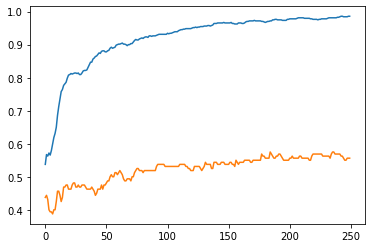

Test accuracy: 57.500000%


In [278]:
base_model = NodeBaseGNN(n, params["hidden_dim"], 2, params["n_layers"], 
                         F.relu, dropout_ratio=params["dropout"]).to(device)
base_train_accuracies, base_val_accuracies, base_test_accuracy = train(base_model, pyg_graph, params)

plt.plot(base_train_accuracies)
plt.plot(base_val_accuracies)
plt.show()
print(f"Test accuracy: {base_test_accuracy:%}")

Next, we see what happens when we replace the final layer with a fully adjacent base self-loop GNN layer.

Epoch 50
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%

Epoch 100
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%

Epoch 150
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%

Epoch 200
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%

Epoch 250
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%



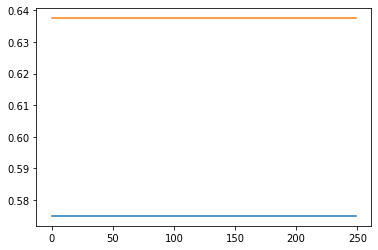

Test accuracy: 58.000000%


In [279]:
fa_model = NodeBaseGNN(n, params["hidden_dim"], 2, params["n_layers"], F.relu, 
                       dropout_ratio=params["dropout"], last_layer_fa = True).to(device)
fa_train_accuracies, fa_val_accuracies, fa_test_accuracy = train(fa_model, pyg_graph, params)

plt.plot(fa_train_accuracies)
plt.plot(fa_val_accuracies)
plt.show()
print(f"Test accuracy: {fa_test_accuracy:%}")

Note that by replacing the final layer with a fully adjacent base self-loop layer, our graph rewiring has made it such that every node shares the same embedding. So, we expect the model to predict every node to have the same label as the one that is most plentiful in the training set. We can verify this by computing the label percentages as below.

In [280]:
training_one = pyg_graph.y[pyg_graph.train_mask].count_nonzero().item()
training_total = pyg_graph.y[pyg_graph.train_mask].size(dim=0)
training_zero = training_total - training_one
print("Training set labels:")
print(f"0: {training_zero / training_total:%}")
print(f"1: {training_one / training_total:%}")

val_one = pyg_graph.y[pyg_graph.val_mask].count_nonzero().item()
val_total = pyg_graph.y[pyg_graph.val_mask].size(dim=0)
val_zero = val_total - val_one
print("Validation set labels:")
print(f"0: {val_zero / val_total:%}")
print(f"1: {val_one / val_total:%}")

test_one = pyg_graph.y[pyg_graph.test_mask].count_nonzero().item()
test_total = pyg_graph.y[pyg_graph.test_mask].size(dim=0)
test_zero = test_total - test_one
print("Test set labels:")
print(f"0: {test_zero / test_total:%}")
print(f"1: {test_one / test_total:%}")

Training set labels:
0: 57.500000%
1: 42.500000%
Validation set labels:
0: 63.750000%
1: 36.250000%
Test set labels:
0: 58.000000%
1: 42.000000%


Finally, we see whether we can use attention to remedy this, by replacing the final layer with a fully adjacent GAT layer.

Epoch 50
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%

Epoch 100
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%

Epoch 150
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%

Epoch 200
----------------------------
Train accuracy: 57.500000%
Validation accuracy: 63.750000%

Epoch 250
----------------------------
Train accuracy: 98.593750%
Validation accuracy: 52.500000%



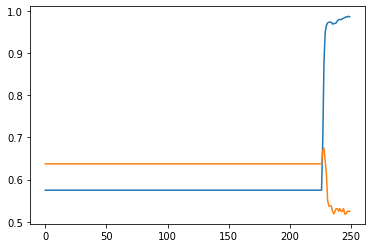

Test accuracy: 63.500000%


In [281]:
fa_gat_model = NodeBaseGNN(n, params["hidden_dim"], 2, params["n_layers"], F.relu, 
                           dropout_ratio=params["dropout"], last_layer_fa_gat = True).to(device)
fa_gat_train_accuracies, fa_gat_val_accuracies, fa_gat_test_accuracy = train(fa_gat_model, pyg_graph, params)

plt.plot(fa_gat_train_accuracies)
plt.plot(fa_gat_val_accuracies)
plt.show()
print(f"Test accuracy: {fa_gat_test_accuracy:%}")

We can show all three sets of training and testing curves together as follows:

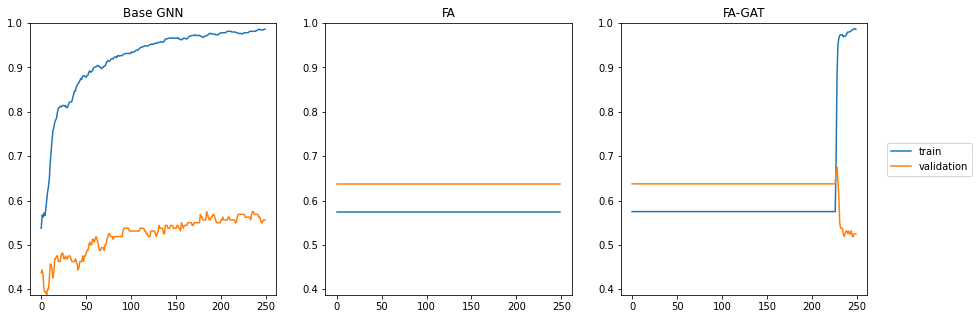

Base GNN
Test accuracy: 57.500000%
FA
Test accuracy: 58.000000%
FA-GAT
Test accuracy: 63.500000%


In [286]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(base_train_accuracies, label="train")
axs[0].plot(base_val_accuracies, label="validation")
axs[0].set_title("Base GNN")

axs[1].plot(fa_train_accuracies, label="train")
axs[1].plot(fa_val_accuracies, label="validation")
axs[1].set_title("FA")

axs[2].plot(fa_gat_train_accuracies, label="train")
axs[2].plot(fa_gat_val_accuracies, label="validation")
axs[2].set_title("FA-GAT")

miny = min(*base_train_accuracies, *base_val_accuracies,
           *fa_train_accuracies, *fa_val_accuracies,
           *fa_gat_train_accuracies, *fa_gat_val_accuracies)
custom_ylim = (miny, 1)
plt.setp(axs, ylim=custom_ylim)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:2], labels[:2], loc="center right")
plt.show()

print("Base GNN")
print(f"Test accuracy: {base_test_accuracy:%}")
print("FA")
print(f"Test accuracy: {fa_test_accuracy:%}")
print("FA-GAT")
print(f"Test accuracy: {fa_gat_test_accuracy:%}")

# **Dataset 2: CORA**
CORA is a commonly used node classification benchmark dataset. We expect to see similar results to above, where `fa_model` tanks model performance because it must give the same prediction for every node, and `fa_gat_model` remedies this using attention.

In [12]:
dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
num_features = dataset.num_node_features
num_classes = dataset.num_classes
cora = dataset[0].to(device)

Processing...
Done!


We compute the label percentages in CORA. Since the training set has equally distributed labels, we expect the model to randomly pick one to predict for all the nodes.

In [13]:
train_counts = {}
for label in cora.y[cora.train_mask].tolist():
    train_counts[label] = train_counts.get(label, 0) + 1
print(train_counts)

total = sum(train_counts.values())
for key, value in train_counts.items():
    train_counts[key] = value / total
print(train_counts)

test_counts = {}
for label in cora.y[cora.test_mask].tolist():
    test_counts[label] = test_counts.get(label, 0) + 1
print(test_counts)

total = sum(test_counts.values())
for key, value in test_counts.items():
    test_counts[key] = value / total
print(test_counts)

{3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
{3: 0.14285714285714285, 4: 0.14285714285714285, 0: 0.14285714285714285, 2: 0.14285714285714285, 1: 0.14285714285714285, 5: 0.14285714285714285, 6: 0.14285714285714285}
{3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}
{3: 0.319, 2: 0.144, 0: 0.13, 1: 0.091, 5: 0.103, 4: 0.149, 6: 0.064}


We set hyperparameters mostly as in Practical 2 - I've just added dropout regularisation and some more epochs

In [14]:
params = {
    "lr": 1e-4,
    "weight_decay": 0,
    "epochs": 500,
    "output_every": 50,
    "hidden_dim": 128,
    "dropout": 0.5,
    "n_layers": 2
}

Epoch 50
----------------------------
Train accuracy: 82.857143%
Validation accuracy: 59.000000%

Epoch 100
----------------------------
Train accuracy: 98.571429%
Validation accuracy: 70.800000%

Epoch 150
----------------------------
Train accuracy: 98.571429%
Validation accuracy: 73.200000%

Epoch 200
----------------------------
Train accuracy: 98.571429%
Validation accuracy: 74.600000%

Epoch 250
----------------------------
Train accuracy: 98.571429%
Validation accuracy: 73.800000%

Epoch 300
----------------------------
Train accuracy: 98.571429%
Validation accuracy: 74.200000%

Epoch 350
----------------------------
Train accuracy: 98.571429%
Validation accuracy: 73.600000%

Epoch 400
----------------------------
Train accuracy: 99.285714%
Validation accuracy: 74.000000%

Epoch 450
----------------------------
Train accuracy: 99.285714%
Validation accuracy: 74.200000%

Epoch 500
----------------------------
Train accuracy: 99.285714%
Validation accuracy: 74.400000%



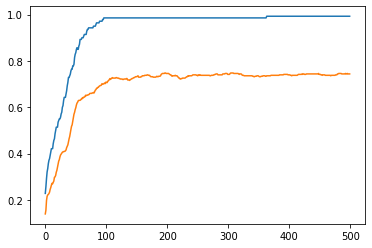

Test accuracy: 74.200000%


In [15]:
base_model = NodeBaseGNN(num_features, params["hidden_dim"], num_classes, params["n_layers"], 
                         F.relu, dropout_ratio=params["dropout"]).to(device)
base_train_accuracies, base_val_accuracies, base_test_accuracy = train(base_model, cora, params)

plt.plot(base_train_accuracies)
plt.plot(base_val_accuracies)
plt.show()
print(f"Test accuracy: {base_test_accuracy:%}")

Epoch 50
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 100
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 150
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 200
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 250
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 300
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 350
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 400
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 450
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%

Epoch 500
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 12.200000%



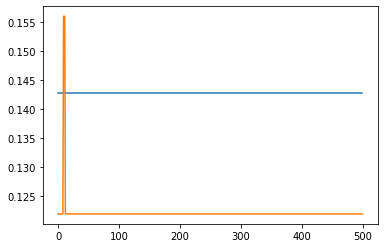

Test accuracy: 14.400000%


In [16]:
fa_model = NodeBaseGNN(num_features, params["hidden_dim"], num_classes, params["n_layers"], F.relu, 
                       dropout_ratio=params["dropout"], last_layer_fa = True).to(device)
fa_train_accuracies, fa_val_accuracies, fa_test_accuracy = train(fa_model, cora, params)

plt.plot(fa_train_accuracies)
plt.plot(fa_val_accuracies)
plt.show()
print(f"Test accuracy: {fa_test_accuracy:%}")

Epoch 50
----------------------------
Train accuracy: 15.000000%
Validation accuracy: 11.400000%

Epoch 100
----------------------------
Train accuracy: 14.285714%
Validation accuracy: 31.600000%

Epoch 150
----------------------------
Train accuracy: 22.142857%
Validation accuracy: 12.200000%

Epoch 200
----------------------------
Train accuracy: 17.857143%
Validation accuracy: 15.600000%

Epoch 250
----------------------------
Train accuracy: 29.285714%
Validation accuracy: 16.800000%

Epoch 300
----------------------------
Train accuracy: 24.285714%
Validation accuracy: 31.600000%

Epoch 350
----------------------------
Train accuracy: 27.142857%
Validation accuracy: 8.400000%

Epoch 400
----------------------------
Train accuracy: 27.142857%
Validation accuracy: 10.600000%

Epoch 450
----------------------------
Train accuracy: 35.714286%
Validation accuracy: 17.800000%

Epoch 500
----------------------------
Train accuracy: 39.285714%
Validation accuracy: 19.600000%



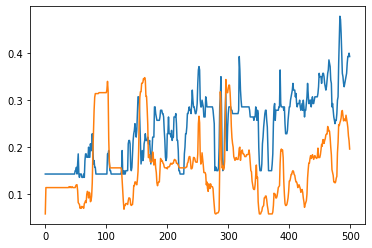

Test accuracy: 34.900000%


In [18]:
fa_gat_model = NodeBaseGNN(num_features, params["hidden_dim"], num_classes, params["n_layers"], F.relu, 
                           dropout_ratio=params["dropout"], last_layer_fa_gat = True).to(device)
fa_gat_train_accuracies, fa_gat_val_accuracies, fa_gat_test_accuracy = train(fa_gat_model, cora, params)

plt.plot(fa_gat_train_accuracies)
plt.plot(fa_gat_val_accuracies)
plt.show()
print(f"Test accuracy: {fa_gat_test_accuracy:%}")

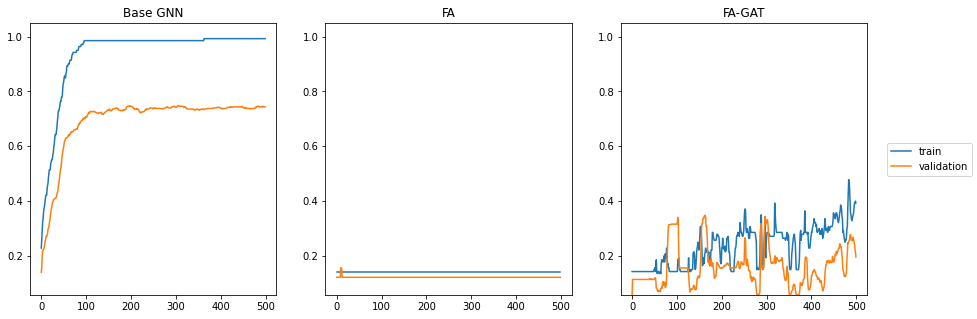

Base GNN
Test accuracy: 74.200000%
FA
Test accuracy: 14.400000%
FA-GAT
Test accuracy: 34.900000%


In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(base_train_accuracies, label="train")
axs[0].plot(base_val_accuracies, label="validation")
axs[0].set_title("Base GNN")

axs[1].plot(fa_train_accuracies, label="train")
axs[1].plot(fa_val_accuracies, label="validation")
axs[1].set_title("FA")

axs[2].plot(fa_gat_train_accuracies, label="train")
axs[2].plot(fa_gat_val_accuracies, label="validation")
axs[2].set_title("FA-GAT")

miny = min(*base_train_accuracies, *base_val_accuracies,
           *fa_train_accuracies, *fa_val_accuracies,
           *fa_gat_train_accuracies, *fa_gat_val_accuracies)
custom_ylim = (miny, 1.05)
plt.setp(axs, ylim=custom_ylim)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:2], labels[:2], loc="center right")
plt.show()

print("Base GNN")
print(f"Test accuracy: {base_test_accuracy:%}")
print("FA")
print(f"Test accuracy: {fa_test_accuracy:%}")
print("FA-GAT")
print(f"Test accuracy: {fa_gat_test_accuracy:%}")

# **Dataset 3: MUTAG**
We now examine the effect of adding a fully adjacent layer on a graph classification task. To avoid long training times, I selected the MUTAG dataset since it was the smallest I could find.

In [289]:
mutag = TUDataset(root='/tmp/MUTAG', name='MUTAG')
mutag.shuffle()
num_classes = mutag.num_classes
num_features = mutag.num_node_features

## **Defining Graph Classification Models**
We need to modify the base GNN model we defined earlier to be able to handle graph classification data. The main differences are: changing how we make a layer fully adjacent to take into account the fact that the data involves multiple graphs in a batch, adding a graph pooling layer at the end to generate graph embeddings, and adding an MLP to act as a classifier on the generated graph embeddings.

In [19]:
class GraphBaseGNNAndMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_gnn_layers, n_mlp_layers, nonlinear, act_fn=nn.ReLU, dropout_ratio=0, last_layer_fa=False, last_layer_fa_gat=False):
        super(GraphBaseGNNAndMLP, self).__init__()

        self.n_gnn_layers = n_gnn_layers
        self.act_fn = act_fn()
        self.dropout_ratio = dropout_ratio
        self.last_layer_fa = last_layer_fa
        self.last_layer_fa_gat = last_layer_fa_gat

        self.layers = nn.ModuleList([BaseConv(input_dim, hidden_dim, nonlinear)]
                                    + [BaseConv(hidden_dim, hidden_dim, nonlinear) for i in range(n_gnn_layers-2)]
                                    + [BaseConv(hidden_dim, hidden_dim, nonlinear)])
        if last_layer_fa:
            self.layers[-1] = BaseSelfLoopConv(hidden_dim, hidden_dim, nonlinear)
        if last_layer_fa_gat:
            self.layers[-1] = GATv2Conv(hidden_dim, hidden_dim)

        self.mlp = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_mlp_layers-1)]
                                 + [nn.Linear(hidden_dim, output_dim)])
        
    def forward(self, data):
        x, edges, batch = data.x, data.edge_index, data.batch
        for i, layer in enumerate(self.layers):
            if i == self.n_gnn_layers - 1 and (self.last_layer_fa or self.last_layer_fa_gat):
                block_map = torch.eq(batch.unsqueeze(0), batch.unsqueeze(-1)).int()
                edges, _ = dense_to_sparse(block_map)
            x = layer.forward(x, edges)
            x = self.act_fn(x)
            if self.dropout_ratio > 0:
                x = F.dropout(x, self.dropout_ratio, training=self.training)

        x = global_mean_pool(x, batch)

        for layer in self.mlp[:-1]:
            x = layer.forward(x)
            x = self.act_fn(x)
            if self.dropout_ratio > 0:
                x = F.dropout(x, self.dropout_ratio, training=self.training)
        # softmax for final layer
        x = self.mlp[-1].forward(x)
        return F.log_softmax(x, dim=1)
    
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()
        for layer in self.mlp:
            layer.reset_parameters()

## **Training and Testing Functions**
We need to change how we train and test to take into account the fact that our data involves multiple graphs and is coming in batches. We also do k-fold cross validation. Most of this code is adapted from Practical 6; the main difference is that we use a validation set and, for each fold, we evaluate the model on the test set when the validation accuracy is best to get the test accuracy for that fold. The test accuracy for a model is then the mean of the test accuracies for its folds.

In [20]:
def train_epoch(dataloader, model, loss_fn, optimiser):
    """Do one epoch-worth of training."""
    
    # Put the model in training mode
    model.train()
    
    # Loop over each batch of datapoints
    for data in dataloader:
        data.to(device)
        
        # Set all the gradients to zero
        optimiser.zero_grad()
        
        # Make a prediction using the current parameters
        pred = model(data)
        
        # Compute the loss for this prediction
        loss = loss_fn(pred, data.y)
        
        # Propagate the loss backwards to compute the gradients
        loss.backward()
        
        # Do one step of optimisation
        optimiser.step()

In [21]:
def train(train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimiser, 
          params):
    """Train a model for a certain number of epochs."""

    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0
    test_accuracy = 0

    # Loop through the epochs
    for t in range(1, params["epochs"]+1):

        # Do the training for this epoch
        train_epoch(train_dataloader, model, loss_fn, optimiser)

        # Evaluate the model on training and validation set
        train_accuracy = test(train_dataloader, model)
        val_accuracy = test(val_dataloader, model)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # If best validation performance, log test accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            test_accuracy = test(test_dataloader, model)

        # Output the accuracy of the model every so often
        if params["output_every"] is not None and t % params["output_every"] == 0:
            print(f"Epoch {t}")
            print("----------------------------")
            print(f"Train accuracy: {train_accuracy:%}")
            print(f"Validation accuracy: {val_accuracy:%}")
            print()
    
    return train_accuracies, val_accuracies, test_accuracy

In [22]:
def test(dataloader, model):
    """Test a model on some data."""
    
    # Put the model in evaluation mode
    model.eval()

    # The number of correct predictions
    correct = 0

    # We don't want to be computing the gradients
    with torch.no_grad():

        # Loop through the minibatches
        for data in dataloader:
            data.to(device)

            # Compute the model predictions
            pred = model(data)

            # Update with the number of correct predictions
            correct += (pred.argmax(1) == data.y).count_nonzero()

    # Compute the accuracy for the whole dataset and return it
    return correct / len(dataloader.dataset)

In [23]:
def cross_validate(dataset, model, params):
    """Use k-fold cross validation to evaluate a model on a dataset."""
    num_splits = params["num_splits"]

    # Get the number of graphs
    size = len(dataset)

    # Arrays to store the train and validation accuracies (per epoch) for each fold
    train_accuracies = []
    val_accuracies = []

    # Array to store test accuracy for each fold
    test_accuracies = []

    # Loss function and optimiser
    # Use NLL as in https://github.com/chrsmrrs/k-gnn/blob/master/examples/1-mutag.py
    loss_fn = F.nll_loss 
    optimiser = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    
    # Loop over the folds
    for fold in range(num_splits): 

        # Print a header to mark this fold
        print(f"Fold {fold+1}")
        print("============================")
        print()

        # Calculate the current fold segment indices
        index_min = int((size * fold) // num_splits)
        index_max = int((size * (fold+1)) // num_splits)

        # Split into train, val and test datasets
        test_dataset = dataset[index_min:index_max]
        train_val_size = size - len(test_dataset)
        val_split = train_val_size // 5 # 20% validation set
        if val_split <= index_min:
            val_dataset = dataset[:val_split]
            train_dataset = dataset[val_split:index_min] + dataset[index_max:]
        else:
            leftover = val_split - index_min
            val_dataset = dataset[:index_min] + dataset[index_max:index_max+leftover]
            train_dataset = dataset[index_max+leftover:]

        # Turn these into torch_geometric dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=params["batch_size"])
        val_dataloader = DataLoader(val_dataset, batch_size=params["batch_size"])
        test_dataloader = DataLoader(test_dataset, batch_size=params["batch_size"])

        # Reset the parameter of the model before training
        model.reset_parameters()

        # Train with these
        fold_train_accuracies, fold_val_accuracies, fold_test_accuracy = train(train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimiser, params)

        # Record the train, val and test accuracies for the fold
        train_accuracies.append(fold_train_accuracies)
        val_accuracies.append(fold_val_accuracies)
        test_accuracies.append(fold_test_accuracy)

    # average across the different folds
    def mean(a):
        return sum(a) / len(a)
    train_accuracies = list(map(mean, zip(*train_accuracies)))
    val_accuracies = list(map(mean, zip(*val_accuracies)))
    return train_accuracies, val_accuracies, test_accuracies

## **Evaluating Models**
As before, we begin by defining the hyperparameters. These are set similarly to Morris et al., 2019 (https://arxiv.org/pdf/1810.02244v5.pdf); the main difference is that I've simplified them a bit (e.g. my lr doesn't decay with a validation set). This paper reports an 82.2% test accuracy on MUTAG when using a base GNN, so we should hopefully see similar-ish results.

In [302]:
params = {
    "lr": 1e-3,
    "weight_decay": 0,
    "epochs": 100,
    "output_every": 20,
    "hidden_dim": 64,
    "dropout": 0.5,
    "n_gnn_layers": 3,
    "n_mlp_layers": 3,
    "num_splits": 10,
    "batch_size": 32
}

We measure the performance of the base GNN model on MUTAG.

Fold 1

Epoch 20
----------------------------
Train accuracy: 72.058821%
Validation accuracy: 70.588237%

Epoch 40
----------------------------
Train accuracy: 75.000000%
Validation accuracy: 73.529410%

Epoch 60
----------------------------
Train accuracy: 77.941179%
Validation accuracy: 73.529410%

Epoch 80
----------------------------
Train accuracy: 83.823532%
Validation accuracy: 76.470590%

Epoch 100
----------------------------
Train accuracy: 84.558821%
Validation accuracy: 73.529410%

Fold 2

Epoch 20
----------------------------
Train accuracy: 74.264705%
Validation accuracy: 84.848487%

Epoch 40
----------------------------
Train accuracy: 75.000000%
Validation accuracy: 81.818181%

Epoch 60
----------------------------
Train accuracy: 75.735295%
Validation accuracy: 81.818181%

Epoch 80
----------------------------
Train accuracy: 76.470590%
Validation accuracy: 90.909094%

Epoch 100
----------------------------
Train accuracy: 77.941179%
Validation accuracy: 87.878788%

Fo

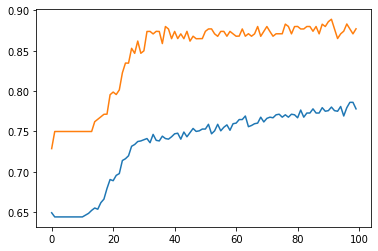

Mean: 72.807020%, Standard Deviation: 7.944517%


In [303]:
base_model = GraphBaseGNNAndMLP(num_features, params["hidden_dim"], num_classes, 
                                params["n_gnn_layers"], params["n_mlp_layers"], F.elu, 
                                dropout_ratio=params["dropout"]).to(device)
base_train_accuracies, base_val_accuracies, base_test_accuracies = cross_validate(mutag, base_model, params)

plt.plot(base_train_accuracies)
plt.plot(base_val_accuracies)
plt.show()

base_test_accuracies = torch.tensor(base_test_accuracies)
print(f"Mean: {base_test_accuracies.mean():%}, Standard Deviation: {base_test_accuracies.std():%}")

Fold 1

Epoch 20
----------------------------
Train accuracy: 69.852942%
Validation accuracy: 73.529410%

Epoch 40
----------------------------
Train accuracy: 74.264705%
Validation accuracy: 73.529410%

Epoch 60
----------------------------
Train accuracy: 77.941179%
Validation accuracy: 70.588237%

Epoch 80
----------------------------
Train accuracy: 83.823532%
Validation accuracy: 73.529410%

Epoch 100
----------------------------
Train accuracy: 80.147058%
Validation accuracy: 79.411763%

Fold 2

Epoch 20
----------------------------
Train accuracy: 73.529410%
Validation accuracy: 81.818181%

Epoch 40
----------------------------
Train accuracy: 73.529410%
Validation accuracy: 81.818181%

Epoch 60
----------------------------
Train accuracy: 76.470590%
Validation accuracy: 84.848487%

Epoch 80
----------------------------
Train accuracy: 77.941179%
Validation accuracy: 81.818181%

Epoch 100
----------------------------
Train accuracy: 80.147058%
Validation accuracy: 84.848487%

Fo

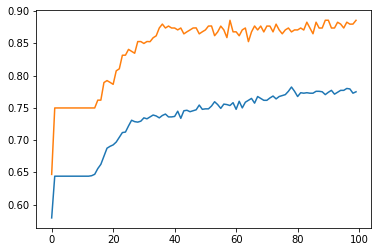

Mean: 73.333335%, Standard Deviation: 9.567358%


In [304]:
fa_model = GraphBaseGNNAndMLP(num_features, params["hidden_dim"], num_classes, 
                              params["n_gnn_layers"], params["n_mlp_layers"], F.elu, 
                              dropout_ratio=params["dropout"]).to(device)
fa_train_accuracies, fa_val_accuracies, fa_test_accuracies = cross_validate(mutag, fa_model, params)

plt.plot(fa_train_accuracies)
plt.plot(fa_val_accuracies)
plt.show()

fa_test_accuracies = torch.tensor(fa_test_accuracies)
print(f"Mean: {fa_test_accuracies.mean():%}, Standard Deviation: {fa_test_accuracies.std():%}")

Fold 1

Epoch 20
----------------------------
Train accuracy: 72.794116%
Validation accuracy: 76.470590%

Epoch 40
----------------------------
Train accuracy: 75.735295%
Validation accuracy: 73.529410%

Epoch 60
----------------------------
Train accuracy: 77.205884%
Validation accuracy: 73.529410%

Epoch 80
----------------------------
Train accuracy: 77.205884%
Validation accuracy: 76.470590%

Epoch 100
----------------------------
Train accuracy: 77.941179%
Validation accuracy: 79.411763%

Fold 2

Epoch 20
----------------------------
Train accuracy: 74.264705%
Validation accuracy: 78.787881%

Epoch 40
----------------------------
Train accuracy: 72.794116%
Validation accuracy: 81.818181%

Epoch 60
----------------------------
Train accuracy: 77.941179%
Validation accuracy: 81.818181%

Epoch 80
----------------------------
Train accuracy: 80.147058%
Validation accuracy: 81.818181%

Epoch 100
----------------------------
Train accuracy: 81.617647%
Validation accuracy: 84.848487%

Fo

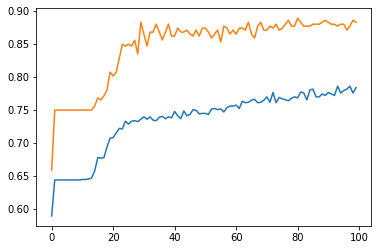

Mean: 76.257306%, Standard Deviation: 12.149115%


In [305]:
fa_gat_model = GraphBaseGNNAndMLP(num_features, params["hidden_dim"], num_classes, 
                                  params["n_gnn_layers"], params["n_mlp_layers"], F.elu, 
                                  dropout_ratio=params["dropout"]).to(device)
fa_gat_train_accuracies, fa_gat_val_accuracies, fa_gat_test_accuracies = cross_validate(mutag, fa_gat_model, params)

plt.plot(fa_gat_train_accuracies)
plt.plot(fa_gat_val_accuracies)
plt.show()

fa_gat_test_accuracies = torch.tensor(fa_gat_test_accuracies)
print(f"Mean: {fa_gat_test_accuracies.mean():%}, Standard Deviation: {fa_gat_test_accuracies.std():%}")

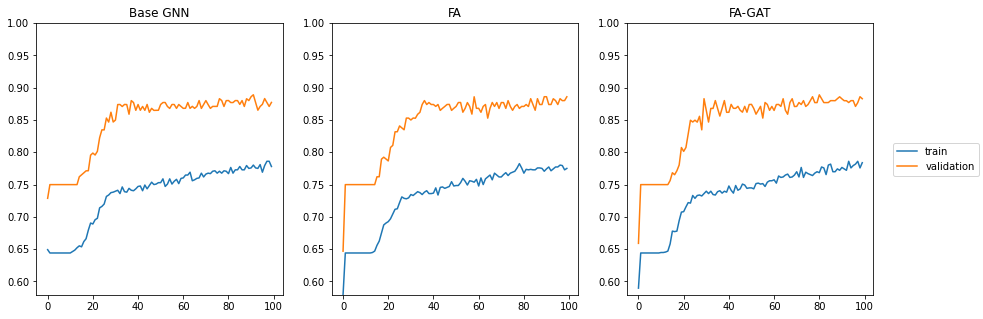

Base GNN
Mean: 72.807020%, Standard Deviation: 7.944517%
FA
Mean: 73.333335%, Standard Deviation: 9.567358%
FA-GAT
Mean: 76.257306%, Standard Deviation: 12.149115%


In [306]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(base_train_accuracies, label="train")
axs[0].plot(base_val_accuracies, label="validation")
axs[0].set_title("Base GNN")

axs[1].plot(fa_train_accuracies, label="train")
axs[1].plot(fa_val_accuracies, label="validation")
axs[1].set_title("FA")

axs[2].plot(fa_gat_train_accuracies, label="train")
axs[2].plot(fa_gat_val_accuracies, label="validation")
axs[2].set_title("FA-GAT")

miny = min(*base_train_accuracies, *base_val_accuracies,
           *fa_train_accuracies, *fa_val_accuracies,
           *fa_gat_train_accuracies, *fa_gat_val_accuracies)
custom_ylim = (miny, 1)
plt.setp(axs, ylim=custom_ylim)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:2], labels[:2], loc="center right")
plt.show()

print("Base GNN")
print(f"Mean: {base_test_accuracies.mean():%}, Standard Deviation: {base_test_accuracies.std():%}")
print("FA")
print(f"Mean: {fa_test_accuracies.mean():%}, Standard Deviation: {fa_test_accuracies.std():%}")
print("FA-GAT")
print(f"Mean: {fa_gat_test_accuracies.mean():%}, Standard Deviation: {fa_gat_test_accuracies.std():%}")